# Figure 2, 3 and 4

## Calling the packages

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

## Calling dask

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="128GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.120.199/484411/1' processes=1 threads=256, memory=119.21 GiB>

## Setting functions

In [3]:
def spatial_mean_model(file,var,times):
    ## Compute the weighted sptail mean 
    ### file :  file of the data set.
    ### var: variable
    ### times : [times_begin times_end] initial and last time of the analysis
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4').sel(
        time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_total = area.sel(lat=slice(-30,30)).sum()
    
    ## Spatial mean
    pr=((dset1[var]*area).sum(dim=('lon','lat'))/area_total)
    return pr.compute()

In [4]:
def cal_area_tropics(file):
    ## Calculate the area in the tropics 
    ### file :  file of the data set.
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
                lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_tropics =  area.sel(lat=slice(-30,30)).sum()
    return area_tropics

#### Compute terms in Equation 4

$\alpha_{0}^{\tau}(t)$ : area fraction of precipitation rates less than $\tau$

$\alpha_{\tau}^{\infty}(t)$ : area fraction of precipitation rates greater than $\tau$

$I_{0}^{\tau}(t)$ : mean intenity of precipitation rates less than $\tau$

$I_{\tau}^{\infty}(t)$ : mean intensity of precipitation rates greater than $\tau$

In [5]:
def intensity_afraction(file,var,times,tau,factor=(1/3600/24)):
    ## Calculate the terms in the tropics
    
    ### file :  file of the data set.
    ### var: variable
    ### times : [times_begin times_end] initial and last time of the analysis
    ### tau : list for the different values of tau (see Equation 4)
    ### factor : 1 when is IMERG; 1/3600/24 when ICON data is used
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
                time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_tropics =  area.sel(lat=slice(-30,30)).sum()
    
    ## I_{0}^{tau}
    intensity_region1 = [] 
    ## I_{tau}^{infinity}
    intensity_region2 = []
    ## alpha_{0}^{tau}
    area_region1 = []
    ## alpha_{tau}^{infinity}
    area_region2 = []
    
    ## Calculate the four components in Equation 4
    for t in range (len(tau)):
        area_region = area.sel(
            lat=slice(-30,30)).where(dset1[var]<tau[t]*factor).sum(dim=('lon','lat')).compute()
        pr_region_1=(
            (dset1[var].where(dset1[var]<tau[t]*factor)*area).sum(dim=('lon','lat'))/area_region).compute()
        pr_region_2=(
            (dset1[var].where(dset1[var]>=tau[t]*factor)*area).sum(dim=('lon','lat'))/(
                area_tropics - area_region)).compute()
        area_region1.append(area_region/area_tropics)
        area_region2.append(1-area_region/area_tropics)
        intensity_region1.append(pr_region_1/factor) 
        intensity_region2.append(pr_region_2/factor)
    return area_region1, area_region2, intensity_region1, intensity_region2

## Computing

### Generate files

In [6]:
#Define a global pattern to find the files
glob_pattern_icon = 'pr_dpp0066_daily'
## Define the paths of file
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip_new/daily')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_icon}*.nc')])[:]

In [7]:
#Define a global pattern to find the files
glob_pattern_imerg = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_imerg}*.nc')])[:]

In [8]:
### Calculate the time series of mean precipitation 

In [9]:
trop_icon = spatial_mean_model(file_icon,'pr',['2020-02-01','2021-01-31'])

In [10]:
trop_imerg = spatial_mean_model(file_imerg,'calibrated_precipitation',['2020-02-01','2021-01-31'])

### Components in Equation 4 

**Tau $\tau$**

In [11]:
limits = [0.1,1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,225,250,275,300]

### Calculation

region1 =>  $\alpha_{0}^{\tau}(t)$, $I_{0}^{\tau}(t)$; 

region2 => $\alpha_{\tau}^{\infty}(t)$ , $I_{\tau}^{\infty}(t)$

#### ICON-Sapphire

In [12]:
icon_area_region1, icon_area_region2, icon_intensity_region1, icon_intensity_region2 = intensity_afraction(
    file_icon,'pr',['2020-02-01','2021-01-31'],limits)

#### IMERG

In [13]:
imerg_area_region1, imerg_area_region2, imerg_intensity_region1, imerg_intensity_region2 = intensity_afraction(
    file_imerg,'calibrated_precipitation',['2020-02-01','2021-01-31'],limits,factor=1)

$\overline{I}_{0}^{\tau}$

In [14]:
mean_icon_intensity_region1 = [(
    (icon_intensity_region1[t].mean())) for t in range (len(limits))]

In [15]:
mean_imerg_intensity_region1 = [(
    (imerg_intensity_region1[t].mean())) for t in range (len(limits)-1)]

$\overline{I}_{\tau}^{\infty}$

In [16]:
mean_icon_intensity_region2 = [(
    (icon_intensity_region2[t].mean())) for t in range (len(limits))]

In [17]:
mean_imerg_intensity_region2 = [(
    (imerg_intensity_region2[t].mean())) for t in range (len(limits)-1)]

$I_{0}^{\tau}(t)^\prime$

In [18]:
anom_icon_intensity_region1 = [(
    (icon_intensity_region1[t] - icon_intensity_region1[t].mean())) for t in range (len(limits))]

In [19]:
anom_imerg_intensity_region1 = [(
    (imerg_intensity_region1[t] - imerg_intensity_region1[t].mean())) for t in range (len(limits)-1)]

$I_{\tau}^{\infty}(t)^\prime$

In [20]:
anom_icon_intensity_region2 = [(
    (icon_intensity_region2[t] - icon_intensity_region2[t].mean())) for t in range (len(limits))]

In [21]:
anom_imerg_intensity_region2 = [(
    (imerg_intensity_region2[t] - imerg_intensity_region2[t].mean())) for t in range (len(limits)-1)]

$\overline{\alpha}_{0}^{\tau}$

In [22]:
mean_icon_area_region1 = [
    (icon_area_region1[t].mean()) for t in range (len(limits))]

In [23]:
mean_imerg_area_region1 = [
    (imerg_area_region1[t].mean()) for t in range (len(limits)-1)]

$\overline{\alpha}_{\tau}^{\infty}$

In [24]:
mean_icon_area_region2 = [
    (icon_area_region2[t].mean()) for t in range (len(limits))]

In [25]:
mean_imerg_area_region2 = [
    (imerg_area_region2[t].mean()) for t in range (len(limits)-1)]

$\alpha_{0}^{\tau}(t)^\prime$

In [26]:
anom_icon_area_region1 = [(
    (icon_area_region1[t] - icon_area_region1[t].mean())) for t in range (len(limits))]

In [27]:
anom_imerg_area_region1 = [(
    (imerg_area_region1[t] - imerg_area_region1[t].mean())) for t in range (len(limits)-1)]

$\alpha_{\tau}^{\infty}(t)^\prime$

In [28]:
anom_icon_area_region2 = [(
    (icon_area_region2[t] - icon_area_region2[t].mean())) for t in range (len(limits))]

In [29]:
anom_imerg_area_region2 = [(
    (imerg_area_region2[t] - imerg_area_region2[t].mean())) for t in range (len(limits)-1)]

$\Delta{I}(t)$

In [30]:
icon_dif_intensity = [((icon_intensity_region2[t]-icon_intensity_region1[t])) for t in range (len(limits))]

In [31]:
imerg_dif_intensity = [((
    imerg_intensity_region2[t]-imerg_intensity_region1[t])) for t in range (len(limits)-1)]

$\overline{\Delta{I}}$

In [32]:
mean_icon_dif_intensity =   [(
    (icon_dif_intensity[t].mean())) for t in range (len(limits))]

In [33]:
mean_imerg_dif_intensity =   [(
    (imerg_dif_intensity[t].mean())) for t in range (len(limits)-1)]

$\Delta{I}(t)^\prime$

In [34]:
anom_icon_dif_intensity = [(
    icon_dif_intensity[t] - (icon_dif_intensity[t].mean())) for t in range (len(limits))]

In [35]:
anom_imerg_dif_intensity = [(
    imerg_dif_intensity[t] - (imerg_dif_intensity[t].mean())) for t in range (len(limits)-1)]

$\overline{\Delta{I}(t)^\prime\alpha_{\tau}^{\infty}(t)^\prime}$

In [36]:
mean_anom_dif_intensity_area2 = [(
    (anom_icon_dif_intensity[t]*anom_icon_area_region2[t]).mean()) for t in range (len(limits))]

In [37]:
mean_anom_imerg_dif_intensity_area2 = [(
    (anom_imerg_dif_intensity[t]*anom_imerg_area_region2[t]).mean()) for t in range (len(limits)-1)]

$\Delta{I}(t)^\prime\alpha_{\tau}^{\infty}(t)^\prime$

In [38]:
anom_dif_intensity_area2 = [((anom_icon_dif_intensity[t]*anom_icon_area_region2[t]))for t in range (len(limits))]

In [39]:
anom_imerg_dif_intensity_area2 = [((
    anom_imerg_dif_intensity[t]*anom_imerg_area_region2[t]))for t in range (len(limits)-1)]

$[P](t)^{\prime}$

In [40]:
icon_pr_anom = trop_icon - trop_icon.mean() 

In [41]:
imerg_pr_anom = trop_imerg - trop_imerg.mean() 

### Correlations

r[$I_{0}^{\tau}(t)^\prime,[P](t)^{\prime}$]

In [42]:
r_icon_intensity1 = np.array(
    [stats.pearsonr(icon_pr_anom,anom_icon_intensity_region1[t])[0] for t in range (len(limits))])

In [43]:
r_imerg_intensity1 = np.array(
    [stats.pearsonr(imerg_pr_anom,anom_imerg_intensity_region1[t])[0] for t in range (len(limits)-1)])

r[$\alpha_{\tau}^{\infty}(t)^\prime,[P](t)^{\prime}$]

In [44]:
r_icon_area2 = np.array(
    [stats.pearsonr(icon_pr_anom,anom_icon_area_region2[t])[0] for t in range (len(limits))])

In [45]:
r_imerg_area2 = np.array(
    [stats.pearsonr(imerg_pr_anom,anom_imerg_area_region2[t])[0] for t in range (len(limits)-1)])

r[$\Delta{I}(t)^\prime,[P](t)^\prime$]

In [46]:
r_icon_dif_intensity = np.array(
    [stats.pearsonr(icon_pr_anom,anom_icon_dif_intensity[t])[0] for t in range (len(limits))])

In [47]:
r_imerg_dif_intensity = np.array(
    [stats.pearsonr(imerg_pr_anom,anom_imerg_dif_intensity[t])[0] for t in range (len(limits)-1)])

r[$\Delta{I}(t)^\prime\alpha_{\tau}^{\infty}(t)^\prime,[P](t)^\prime$]

In [48]:
r_icon_tensor2 = np.array(
    [stats.pearsonr(icon_pr_anom,anom_dif_intensity_area2[t])[0] for t in range (len(limits))])

In [49]:
r_imerg_tensor2 = np.array(
    [stats.pearsonr(
        imerg_pr_anom,anom_imerg_dif_intensity_area2[t])[0] for t in range (len(limits)-1)])

### Constraining the convective region

$\alpha_{20}^{70}(t)$

In [50]:
area_imerg_20_70 = imerg_area_region2[8] - imerg_area_region2[16] 

In [51]:
area_icon_20_70 = icon_area_region2[8] - icon_area_region2[16] 

$\alpha_{20}^{70}(t)^\prime$

In [52]:
anom_area_imerg_20_70 = area_imerg_20_70 - area_imerg_20_70.mean()

In [53]:
anom_area_icon_20_70 = area_icon_20_70 - area_icon_20_70.mean()

## Plotting

### Figure 2

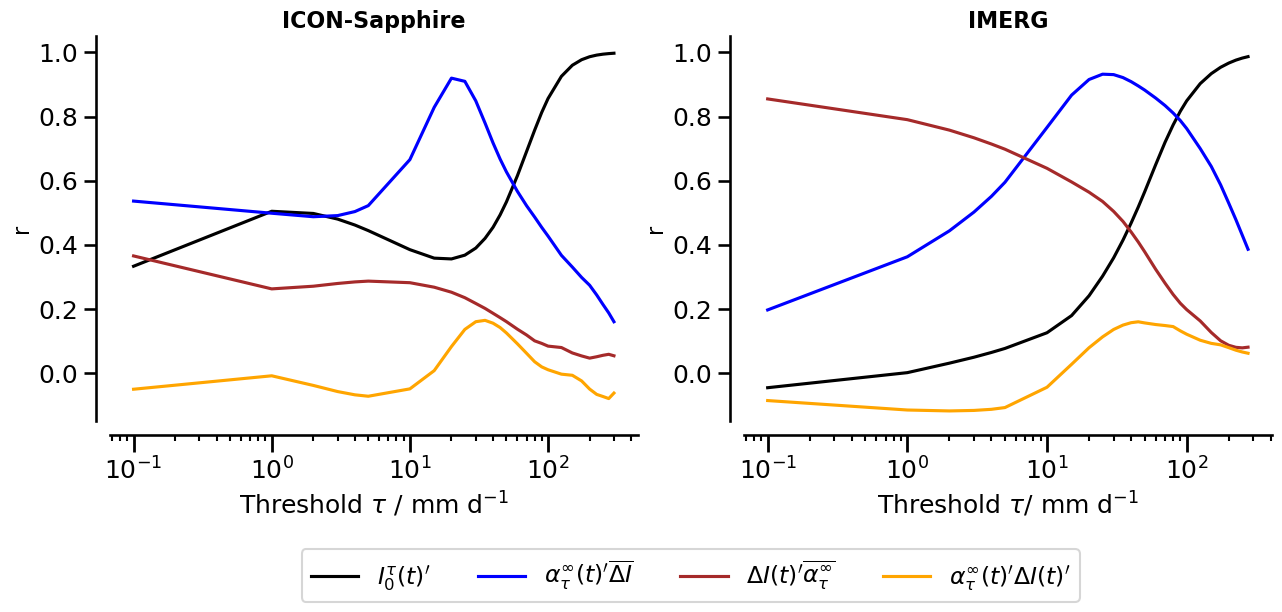

In [54]:
sns.set_context("talk")
fig = plt.figure(figsize=(15, 5),facecolor='white')
ax = fig.add_subplot(121)
lb1 = ax.plot(limits,r_icon_intensity1,'-',color='k',label = r"$I^{\tau}_{0}(t)'$")
#lb2 =ax.plot(limits,r_dpp_intensity2,'-',color='gray',label = r"$I^{\infty}_{\tau}(t)'$")
lb3 =ax.plot(limits,r_icon_area2,'-b',label = r"$\alpha^{\infty}_{\tau}(t)'\overline{\Delta{I}}$")
lb4 =ax.plot(limits,r_icon_dif_intensity,'-',color='brown',label = r"$\Delta{I}(t)'\overline{\alpha^{\infty}_{\tau}}$")
lb5 =ax.plot(limits,r_icon_tensor2,'-',color='orange',label=r"$\alpha^{\infty}_{\tau}(t)'\Delta{I}(t)'$")
ax.set_xscale('log'); ax.set_ylim([-0.15,1.05])
ax.tick_params(labelsize=18);
ax.set_ylabel('r',fontsize=16);ax.set_xlabel(r"Threshold $\tau$ / mm d$^{-1}$",fontsize=18)
ax.tick_params(axis='x',which='minor',length=4);ax.tick_params(axis='x',which='major',length=12.5,width=2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title('ICON-Sapphire',fontsize=16,fontweight='bold')

ax = fig.add_subplot(122)
ax.plot(limits[:-1],r_imerg_intensity1,'-',color='k')
#ax.plot(limits[:-1],r_imerg_intensity2,'-',color='gray')
ax.plot(limits[:-1],r_imerg_area2,'-b')
ax.plot(limits[:-1],r_imerg_dif_intensity,'-',color='brown')
ax.plot(limits[:-1],r_imerg_tensor2,'-',color='orange')
ax.set_xscale('log'); ax.set_ylim([-0.15,1.05])
ax.tick_params(labelsize=18);
ax.set_ylabel('r',fontsize=16);ax.set_xlabel(r"Threshold $\tau$/ mm d$^{-1}$",fontsize=18)
ax.tick_params(axis='x',which='minor',length=4);ax.tick_params(axis='x',which='major',length=12.5,width=2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title('IMERG',fontsize=16,fontweight='bold')
sns.despine(offset=10)
lns = lb1+lb3+lb4+lb5
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(-0.1, -0.5),
          ncol=5, fancybox=True, shadow=False, fontsize=17)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/correlation_components_equation_precip_vairbaility_dpp0066_imerg.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

### Figure 3

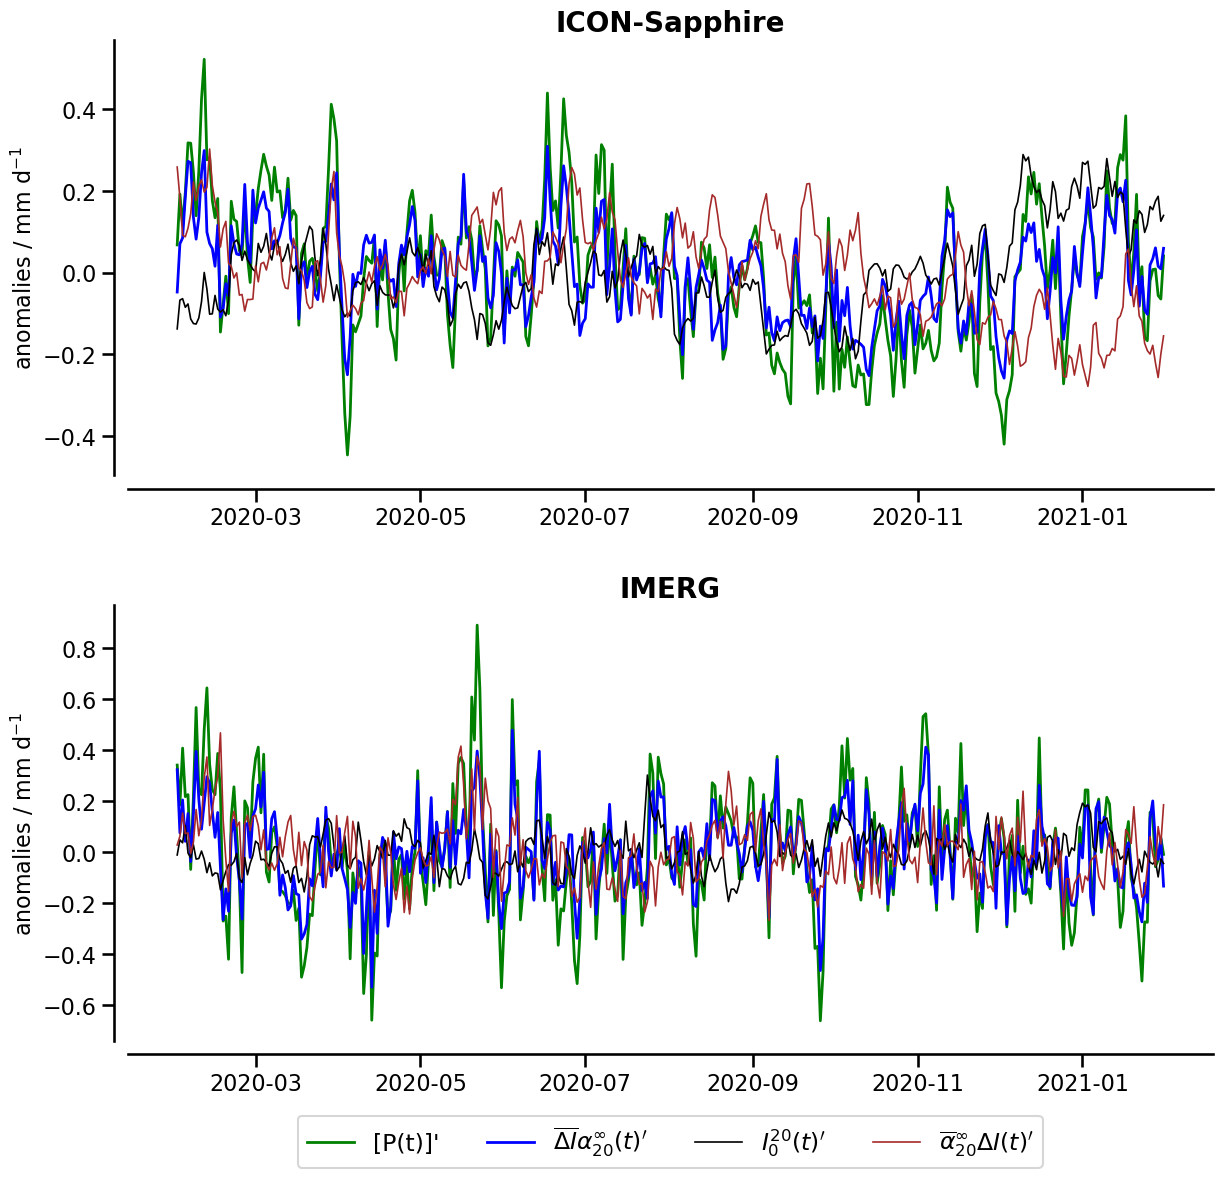

In [55]:
fig = plt.figure(figsize=(14, 13),facecolor='white')
ax = fig.add_subplot(211)
lb1=(icon_pr_anom*24*3600).plot(color='g',linewidth=2,label=r"[P(t)]'")
lb4=(anom_icon_area_region2[8]*mean_icon_dif_intensity[8]).plot(color='blue',linewidth=2,label=r"$\overline{\Delta{I}}$ * $\alpha_{2}'$")
lb2=(anom_icon_intensity_region1[8]).plot(color='black',linewidth=1.2,label="I$_{1}'$")
lb3=(mean_icon_area_region2[8]*anom_icon_dif_intensity[8]).plot(color='brown',
                                                              label=r"$\overline{\alpha}_{2}$ * $\Delta{I}'$"
                                                               ,linewidth=1.2)
ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_xlabel(None)
ax.set_title('ICON-Sapphire',fontsize=20,fontweight='bold')

ax = fig.add_subplot(212)
lb1=(imerg_pr_anom).plot(color='g',linewidth=2,
        label=r"[P(t)]'")
lb4=(anom_imerg_area_region2[8]*mean_imerg_dif_intensity[8]).plot(color='blue',linewidth=2,
        label=r"$\overline{\Delta{I}}\alpha_{20}^{\infty}(t)'$")
lb2=(anom_imerg_intensity_region1[8]).plot(color='black',linewidth=1.2,label=r"$I^{20}_{0}(t)'$")
lb3=(mean_imerg_area_region2[8]*anom_imerg_dif_intensity[8]).plot(color='brown',linewidth=1.2,
                                label=r"$\overline{\alpha}^{\infty}_{20}\Delta{I}(t)'$",)
ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_title('IMERG',fontsize=20,fontweight='bold')
lns = lb1+lb4+lb2+lb3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=4, fancybox=True, shadow=False, fontsize=17)
sns.despine(offset=10)
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/precip_anomalies_dpp0066_imerg_components_only.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

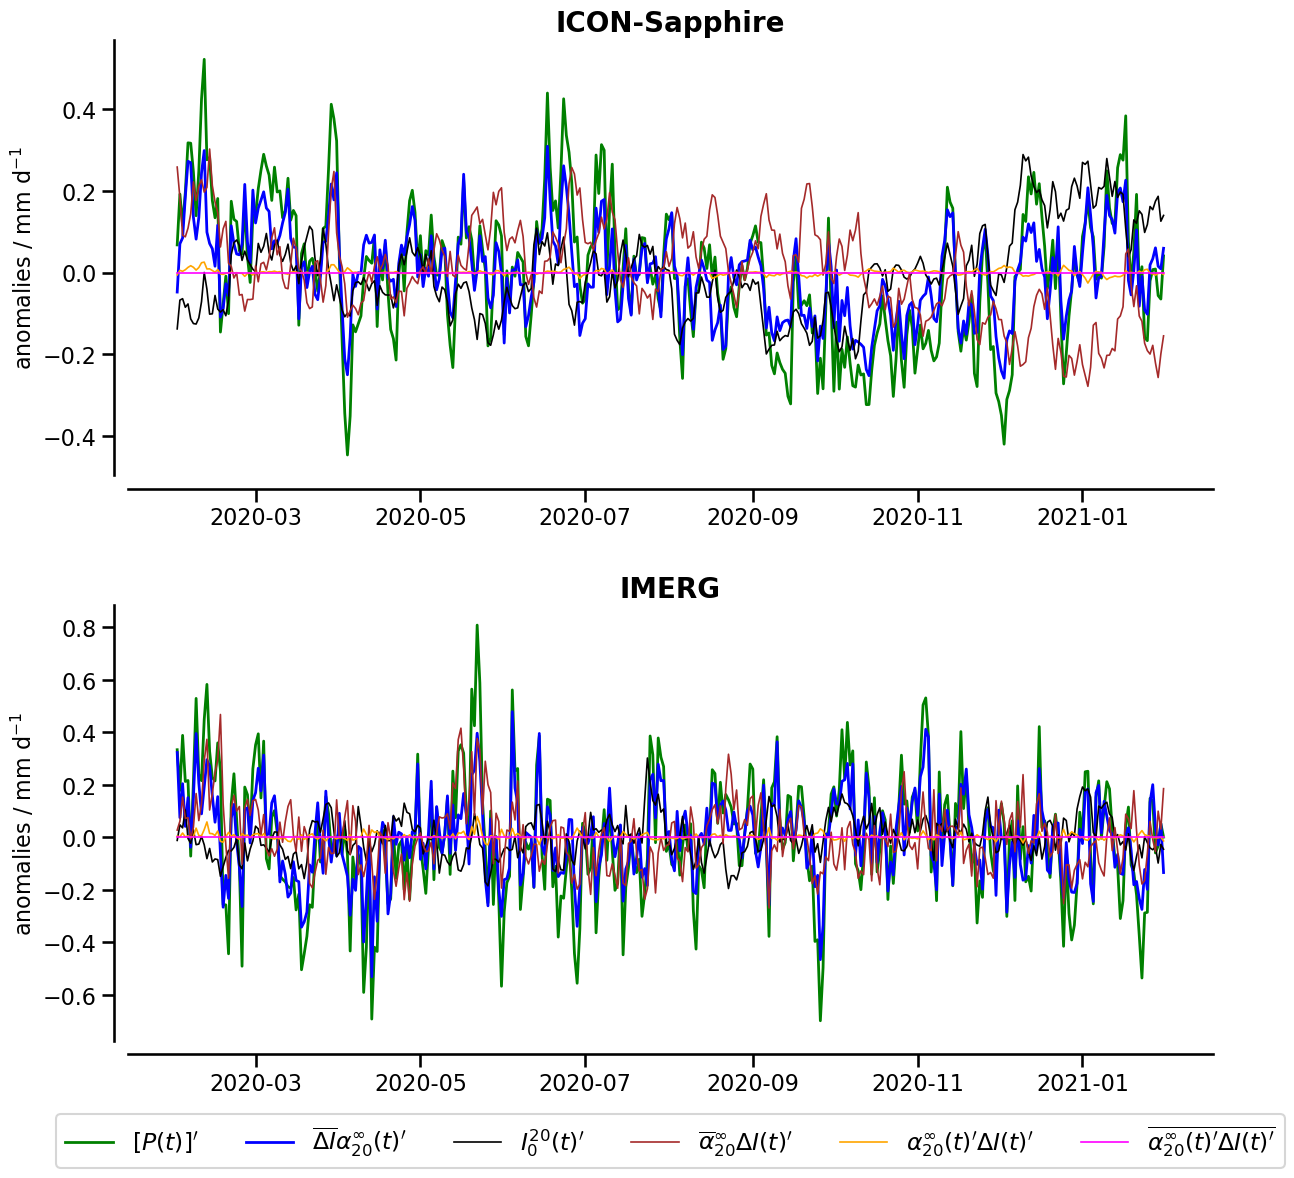

In [56]:
fig = plt.figure(figsize=(14, 13),facecolor='white')
ax = fig.add_subplot(211)
lb1=(icon_pr_anom*24*3600).plot(color='g',linewidth=2,label=r"[P(t)]'")
lb4=(anom_icon_area_region2[8]*mean_icon_dif_intensity[8]).plot(color='blue',linewidth=2,label=r"$\overline{\Delta{I}}$ * $\alpha_{2}'$")
lb2=(anom_icon_intensity_region1[8]).plot(color='black',label="I$_{1}'$",linewidth=1.2)
lb3=(mean_icon_area_region2[8]*anom_icon_dif_intensity[8]).plot(color='brown',linewidth=1.2,
                                                              label=r"$\overline{\alpha}_{2}$ * $\Delta{I}'$")
lb5= (anom_icon_dif_intensity[8]*anom_icon_area_region2[8]).plot(color='orange',linewidth=1.2,
                                                                label=r"$\alpha^{\infty}_{20}(t)'\Delta{I}(t)'$")
lb6= plt.plot([icon_pr_anom.time[0].data,icon_pr_anom.time[-1].data],
              [mean_anom_dif_intensity_area2[8],mean_anom_dif_intensity_area2[8]],
             color='magenta',linewidth=1.2,label =r"$\overline{\alpha^{\infty}_{20}(t)'\Delta{I}(t)'}$")

ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_xlabel(None)
ax.set_title('ICON-Sapphire',fontsize=20,fontweight='bold')

ax = fig.add_subplot(212)
lb1=(imerg_pr_anom-anom_imerg_dif_intensity[8]*anom_imerg_area_region2[8]
    -mean_anom_imerg_dif_intensity_area2[8]).plot(color='g',linewidth=2,
        label=r"$[P(t)]'$")
lb4=(anom_imerg_area_region2[8]*mean_imerg_dif_intensity[8]).plot(color='blue',linewidth=2,
        label=r"$\overline{\Delta{I}}\alpha_{20}^{\infty}(t)'$")
lb2=(anom_imerg_intensity_region1[8]).plot(color='black',linewidth=1.2,label=r"$I^{20}_{0}(t)'$")
lb3=(mean_imerg_area_region2[8]*anom_imerg_dif_intensity[8]).plot(color='brown',linewidth=1.2,
                                label=r"$\overline{\alpha}^{\infty}_{20}\Delta{I}(t)'$")

lb5= (anom_imerg_dif_intensity[8]*anom_imerg_area_region2[8]).plot(color='orange',linewidth=1.2,
                                                                  label=r"$\alpha^{\infty}_{20}(t)'\Delta{I}(t)'$")
lb6= plt.plot([imerg_pr_anom.time[0].data,imerg_pr_anom.time[-1].data],
              [mean_anom_imerg_dif_intensity_area2[8],mean_anom_imerg_dif_intensity_area2[8]],
             color='magenta',linewidth=1.2,label =r"$\overline{\alpha^{\infty}_{20}(t)'\Delta{I}(t)'}$")

ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_title('IMERG',fontsize=20,fontweight='bold')
lns = lb1+lb4+lb2+lb3+lb5+lb6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=6, fancybox=True, shadow=False, fontsize=17)
sns.despine(offset=10)
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/precip_anomalies_dpp0066_imerg_components_complete.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

### Figure 4

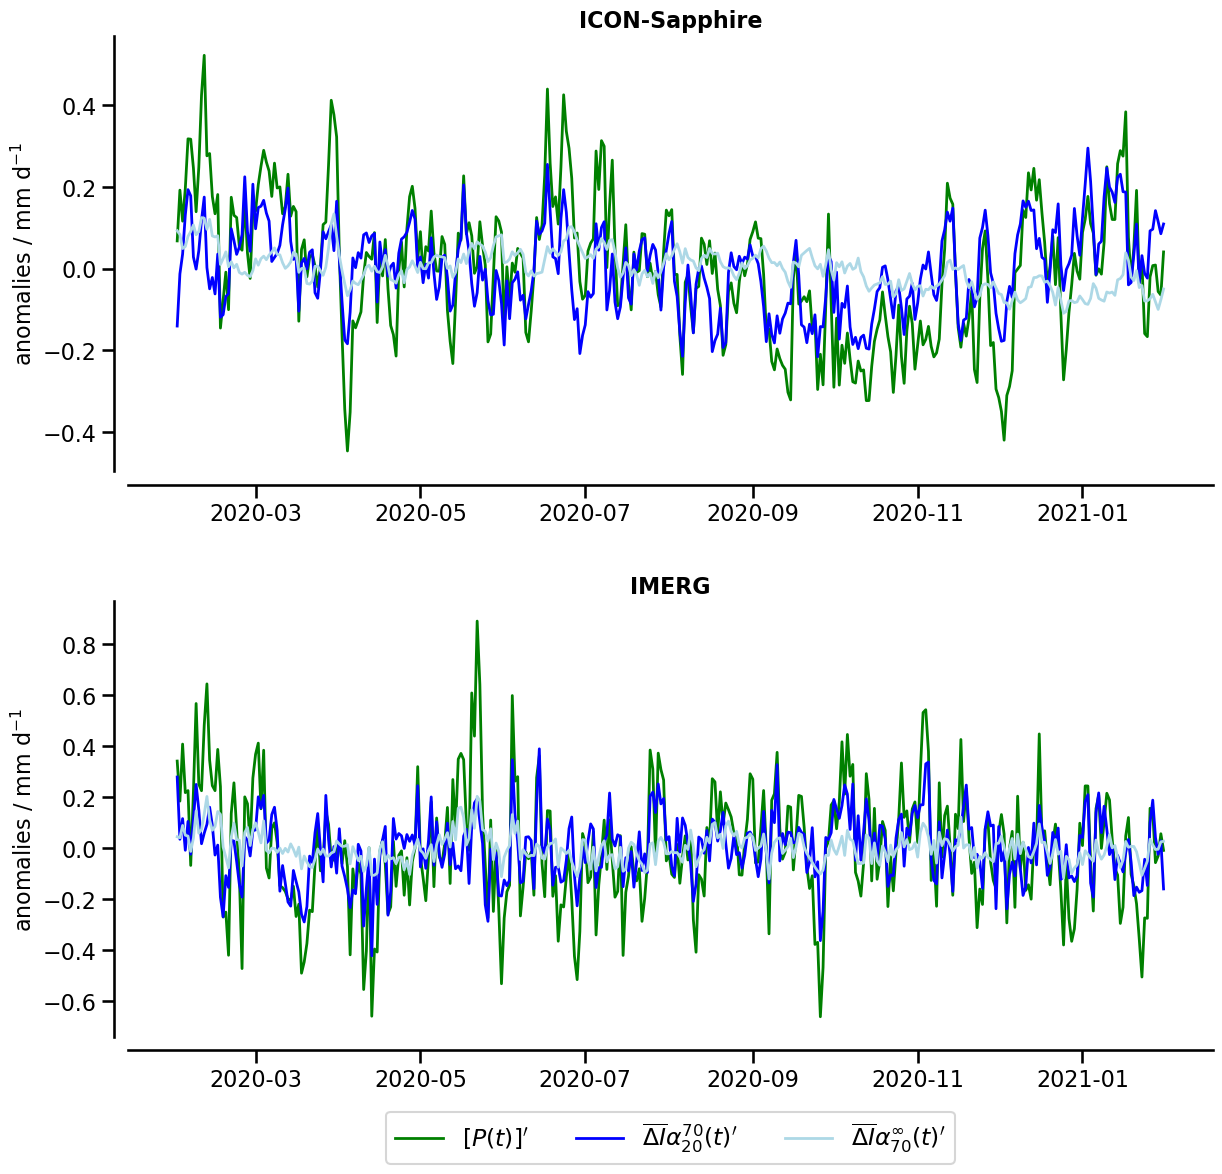

In [57]:
fig = plt.figure(figsize=(14, 13),facecolor='white')
ax = fig.add_subplot(211)
lb1=(icon_pr_anom*24*3600).plot(color='g',linewidth=2,label=r"[P(t)]'")
lb2=(anom_area_icon_20_70*mean_icon_dif_intensity[8]).plot(color='blue',linewidth=2,label=r"$\overline{\Delta{I}}$ * $\alpha_{20-70}'$")
lb3=(anom_icon_area_region2[16]*mean_icon_dif_intensity[8]).plot(color='lightblue',linewidth=2,label=r"$\overline{\Delta{I}}$ * $\alpha_{>70}'$",
                                                                linestyle='-')
ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_xlabel(None)
ax.set_title(r"ICON-Sapphire",fontsize=16,fontweight='bold')


ax = fig.add_subplot(212)
lb1=(imerg_pr_anom).plot(color='g',linewidth=2,
    label=r"$[P(t)]'$")
lb2=(anom_area_imerg_20_70*mean_imerg_dif_intensity[8]).plot(color='blue',linewidth=2,
                            label=r"$\overline{\Delta{I}}\alpha_{20}^{70}(t)'$")
lb3=(anom_imerg_area_region2[16]*mean_imerg_dif_intensity[8]).plot(color='lightblue',linewidth=2,linestyle='-',
                                    label=r"$\overline{\Delta{I}}\alpha_{70}^{\infty}(t)'$")
ax.tick_params(labelsize=16);
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('anomalies / mm d$^{-1}$',fontsize=16)
ax.set_xlabel(None)
ax.set_title(r"IMERG",fontsize=16,fontweight='bold')
#ax.set_title(r"IMERG(PP$^\prime$ vs $\alpha_{PP:20-70}^\prime$) r$_{seasonal}$ = 0.76; r$_{no-seasonal}$ = 0.75",fontsize=16,fontweight='bold')

lns = lb1+lb2+lb3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.32),
          ncol=4, fancybox=True, shadow=False, fontsize=17)
sns.despine(offset=10)
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/precip_anomalies_dpp0066_imerg_components_20_70_higher_70.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

## Table 1

**No removing the seasonal cycle**

r[$[P](t)^\prime,\alpha_{20}^{\infty}(t)^\prime$]

In [57]:
r_area_icon_20_infty = r_icon_area2[8]
r_area_imerg_20_infty = r_imerg_area2[8]
print('icon:' + str(r_area_icon_20_infty))
print('imerg:' + str(r_area_imerg_20_infty))

icon:0.9195939432635512
imerg:0.9153514452083182


r[$[P](t)^\prime,\alpha_{20}^{70}(t)^\prime$]

In [58]:
r_area_icon_20_70  = stats.pearsonr(anom_area_icon_20_70,icon_pr_anom)[0]
r_area_imerg_20_70  = stats.pearsonr(anom_area_imerg_20_70,imerg_pr_anom)[0]
print('icon:' + str(r_area_icon_20_70))
print('imerg:' + str(r_area_imerg_20_70))

icon:0.7480116790559088
imerg:0.7638181963573819


r[$[P](t)^\prime,\alpha_{70}^{\infty}(t)^\prime$]

In [59]:
r_area_icon_70_infty  = stats.pearsonr(anom_icon_area_region2[16],icon_pr_anom)[0]
r_area_imerg_70_infty  = stats.pearsonr(anom_imerg_area_region2[16],imerg_pr_anom)[0]
print('icon:' + str(r_area_icon_70_infty))
print('imerg:' + str(r_area_imerg_70_infty))

icon:0.5217286660994547
imerg:0.8342269956639347


**Removing seasonal cycle**

A moving average with a window of 60 days is used

r[$[P](t)^\prime,\alpha_{20}^{\infty}(t)^\prime$]

In [60]:
r_dseason_area_icon_20_infty = stats.pearsonr((anom_icon_area_region2[8] - 
                anom_icon_area_region2[8].rolling(time=60,center=True).mean())[30:-29],
               (icon_pr_anom - icon_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]
r_dseason_area_imerg_20_infty = stats.pearsonr((anom_imerg_area_region2[8] - 
                anom_imerg_area_region2[8].rolling(time=60,center=True).mean())[30:-29],
               (imerg_pr_anom - imerg_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]

print('icon:' + str(r_dseason_area_icon_20_infty))
print('imerg:' + str(r_dseason_area_imerg_20_infty))

icon:0.8967305882581125
imerg:0.9029922718482102


r[$[P](t)^\prime,\alpha_{20}^{70}(t)^\prime$]

In [61]:
r_dseason_area_icon_20_70 = stats.pearsonr((anom_area_icon_20_70 - 
                anom_area_icon_20_70.rolling(time=60,center=True).mean())[30:-29],
               (icon_pr_anom - icon_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]
r_dseason_area_imerg_20_70 = stats.pearsonr((anom_area_imerg_20_70 - 
                anom_area_imerg_20_70.rolling(time=60,center=True).mean())[30:-29],
               (imerg_pr_anom - imerg_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]

print('icon:' + str(r_dseason_area_icon_20_70))
print('imerg:' + str(r_dseason_area_imerg_20_70))

icon:0.7607744206496363
imerg:0.7529920367373113


r[$[P](t)^\prime,\alpha_{70}^{\infty}(t)^\prime$]

In [62]:
r_dseason_area_icon_70_infty = stats.pearsonr((anom_icon_area_region2[16] - 
                anom_icon_area_region2[16].rolling(time=60,center=True).mean())[30:-29],
               (icon_pr_anom - icon_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]
r_dseason_area_imerg_70_infty = stats.pearsonr((anom_imerg_area_region2[16] - 
                anom_imerg_area_region2[16].rolling(time=60,center=True).mean())[30:-29],
               (imerg_pr_anom - imerg_pr_anom.rolling(time=60,center=True).mean())[30:-29])[0]

print('icon:' + str(r_dseason_area_icon_70_infty))
print('imerg:' + str(r_dseason_area_imerg_70_infty))

icon:0.5850221784039602
imerg:0.8132718149174367


## Answer to reviewers

In [55]:
stats.pearsonr(icon_pr_anom,anom_icon_intensity_region1[0])

PearsonRResult(statistic=0.3333265027639788, pvalue=6.023396238162009e-11)

In [56]:
stats.pearsonr(icon_pr_anom,anom_icon_area_region1[0])

PearsonRResult(statistic=-0.5363790894015418, pvalue=1.1833266915813046e-28)

In [57]:
stats.pearsonr(icon_pr_anom,anom_icon_area_region2[0])

PearsonRResult(statistic=0.5363790894015419, pvalue=1.1833266915812373e-28)

In [63]:
stats.pearsonr(imerg_pr_anom,anom_imerg_area_region2[0])

PearsonRResult(statistic=0.19717243284945007, pvalue=0.0001467160280054344)

In [64]:
stats.pearsonr(imerg_pr_anom,anom_imerg_intensity_region1[0])

PearsonRResult(statistic=-0.045285580381083726, pvalue=0.38767366692469435)

In [65]:
stats.pearsonr(icon_pr_anom,anom_icon_intensity_region1[0])

PearsonRResult(statistic=0.3333265027639788, pvalue=6.023396238162009e-11)

In [58]:
stats.pearsonr(anom_icon_intensity_region1[0],anom_icon_area_region1[0])

PearsonRResult(statistic=-0.595965005009961, pvalue=1.452944741514462e-36)

In [60]:
stats.pearsonr(anom_imerg_intensity_region1[0],anom_imerg_area_region1[0])

PearsonRResult(statistic=-0.6928207567270731, pvalue=1.2351259176881388e-53)

In [124]:
stats.pearsonr(anom_imerg_area_region1[0],anom_imerg_area_region2[20])

PearsonRResult(statistic=0.20313028955674436, pvalue=9.089405180402849e-05)

In [125]:
stats.pearsonr(anom_icon_area_region1[0],anom_icon_area_region2[20])

PearsonRResult(statistic=0.275027052975933, pvalue=8.940376191839568e-08)

In [95]:
stats.pearsonr(anom_imerg_area_region1[0],imerg_area_region2[7]-imerg_area_region2[8])

PearsonRResult(statistic=-0.5199220595035048, pvalue=9.822567611727317e-27)

In [103]:
stats.pearsonr(anom_icon_area_region1[0],anom_icon_area_region2[7]-anom_icon_area_region2[8])

PearsonRResult(statistic=-0.6881667897869019, pvalue=1.1629280565174677e-52)